# Kalman Filter (KF)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Basics of kalman filter

### Predict step:

1. forecast the next future state of the system based on the model’s known posteriori estimates and step in time of Δk
$$ \hat{x}_{k|k-1} = F_k\hat{x}_{k-1|k-1} + B_ku_k  $$
    - F -> state transition matrix models how the states evolve one step to another irrespective of the control input and process noise
    - B -> models the control input, uₖ, impact on the state
3. calculate the uncertainty of the estimate represented by the covariance matrix P
$$ P_{k|k-1} = F_kP_{k-1|k-1}F^T_k + Q_k$$
    - Q -> process noise covariance matrix from the system

### Update setp:
1. updates to the Kalman Gain, State estimates and the Covariance matrix
$$ K_k = P_{k|k-1}H^T_k(H_kP_{k|k-1}H^T_k + R_k)^{-1} $$
    - K -> attempts to balance uncertainty in the predictions with that present in the measurements
    - H -> observation model matrix which relates the state to the measurement we expect to receive
    - R -> measurement noise covariance matrix of errors in the measurments
3. Kalman Gain is applied to correct the state estimates
$$ \hat{x}_{k|k-1} = \hat{x}_{k|k-1} + K_k(y_k - H_k\hat{x}_{k|k-1}) $$
4. Kalman Gain is applied to correct the covariance
$$ P_{k|k-1} = (I - K_kH_k)P_{k|k-1} $$

## Kalman Filter

In [2]:
class KalmanFilter:
    """
    An implementation of the classic Kalman Filter for linear dynamic systems.
    The Kalman Filter is an optimal recursive data processing algorithm which
    aims to estimate the state of a system from noisy observations.

    Attributes:
        F (np.ndarray): The state transition matrix.
        B (np.ndarray): The control input marix.
        H (np.ndarray): The observation matrix.
        u (np.ndarray): the control input.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The mean state estimate of the previous step (k-1).
        P (np.ndarray): The state covariance of previous step (k-1).
    """
    def __init__(self, F, B, u, H, Q, R, x0, P0):
        """
        Initializes the Kalman Filter with the necessary matrices and initial state.

        Parameters:
            F (np.ndarray): The state transition matrix.
            B (np.ndarray): The control input marix.
            H (np.ndarray): The observation matrix.
            u (np.ndarray): the control input.
            Q (np.ndarray): The process noise covariance matrix.
            R (np.ndarray): The measurement noise covariance matrix.
            x0 (np.ndarray): The initial state estimate.
            P0 (np.ndarray): The initial state covariance matrix.
        """
        self.F = F 
        self.B = B
        self.u = u
        self.H = H
        self.Q = Q
        self.R = R
        self.x = x0
        self.P = P0

    def predict(self):
        """
        Predicts the state and the state covariance for the next time step.
        """
        self.x = self.F @ self.x + self.B @ self.u
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.x

    def update(self, z):
        """
        Updates the state estimate with the latest measurement.

        Parameters:
            z (np.ndarray): The measurement at the current step.
        """
        y = z - self.H @ self.x
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = self.P - K @ self.H @ self.P 

        return self.x

### KF estimation over time

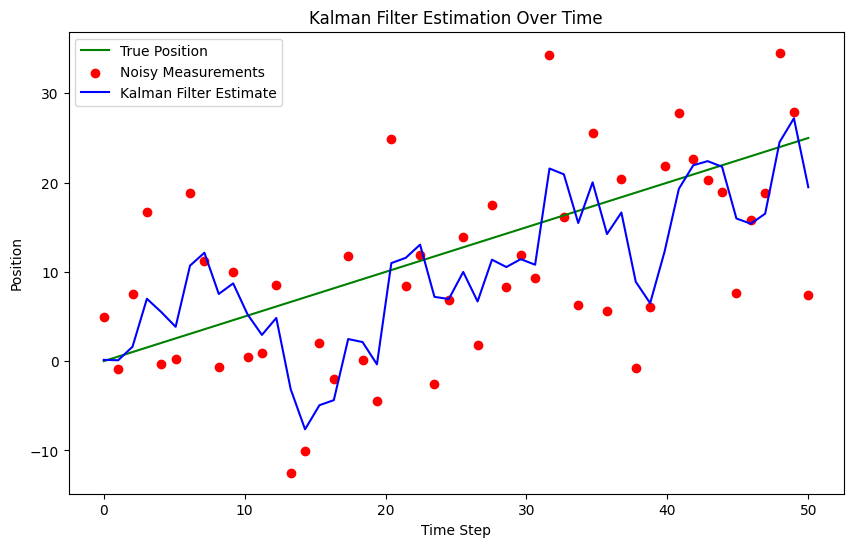

In [3]:
# set the random seed for reproducibility
np.random.seed(42)

# simulate the ground truth position of the object
true_velocity = 0.5  # units per time step
num_steps = 50
time_steps = np.linspace(0, num_steps, num_steps)
true_positions = true_velocity * time_steps

# simulate the measurements with noise
measurement_noise = 10 
noisy_measurements = true_positions + np.random.normal(0, measurement_noise, num_steps)

# Kalman Filter initialization
F = np.array([[1, 1], [0, 1]])
B = np.array([[0], [0]])
u = np.array([[0]])
H = np.array([[1, 0]])
Q = np.array([[1, 0], [0, 3]])
R = np.array([[measurement_noise**2]])
x0 = np.array([[0], [0]])
P0 = np.array([[1, 0], [0, 1]])

kf = KalmanFilter(F, B, u, H, Q, R, x0, P0)

# allocate space for estimated positions and velocities
estimated_positions = np.zeros(num_steps)
estimated_velocities = np.zeros(num_steps)

# kalman Filter Loop
for t in range(num_steps):
    kf.predict()

    measurement = np.array([[noisy_measurements[t]]])
    kf.update(measurement)
    
    # store the filtered position and velocity
    estimated_positions[t] = kf.x[0][0]
    estimated_velocities[t] = kf.x[1][0]

# TODO: replace this by bokeh
# plot the true positions, noisy measurements, and the Kalman filter estimates
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_positions, label='True Position', color='green')
plt.scatter(time_steps, noisy_measurements, label='Noisy Measurements', color='red', marker='o')
plt.plot(time_steps, estimated_positions, label='Kalman Filter Estimate', color='blue')

plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Kalman Filter Estimation Over Time')
plt.legend()
plt.show()

### tracking moving object in 4D

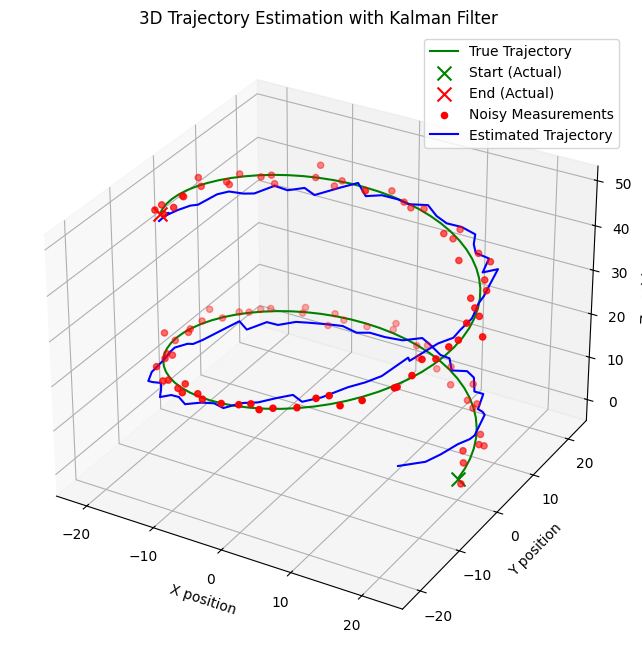

In [4]:
# Parameters for simulation
true_angular_velocity = 0.1  # radians per time step
radius = 20
num_steps = 100
dt = 1  # time step

# Create time steps
time_steps = np.arange(0, num_steps*dt, dt)

# Ground truth state
true_x_positions = radius * np.cos(true_angular_velocity * time_steps)
true_y_positions = radius * np.sin(true_angular_velocity * time_steps)
true_z_positions = 0.5 * time_steps  # constant velocity in z

# Create noisy measurements
measurement_noise = 1.0
noisy_x_measurements = true_x_positions + np.random.normal(0, measurement_noise, num_steps)
noisy_y_measurements = true_y_positions + np.random.normal(0, measurement_noise, num_steps)
noisy_z_measurements = true_z_positions + np.random.normal(0, measurement_noise, num_steps)

# Kalman Filter initialization
F = np.array([[1, 0, 0, -radius*dt*np.sin(true_angular_velocity*dt)],
              [0, 1, 0, radius*dt*np.cos(true_angular_velocity*dt)],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
B = np.zeros((4, 1))
u = np.zeros((1, 1))
H = np.array([[1, 0, 0, 0],
              [0, 1, 0, 0],
              [0, 0, 1, 0]])
Q = np.eye(4) * 0.1  # Small process noise
R = measurement_noise**2 * np.eye(3)  # Measurement noise
x0 = np.array([[0], [radius], [0], [true_angular_velocity]])
P0 = np.eye(4) * 1.0

kf = KalmanFilter(F, B, u, H, Q, R, x0, P0)

# Allocate space for estimated states
estimated_states = np.zeros((num_steps, 4))

# Kalman Filter Loop
for t in range(num_steps):
    # Predict
    kf.predict()
    
    # Update
    z = np.array([[noisy_x_measurements[t]],
                  [noisy_y_measurements[t]],
                  [noisy_z_measurements[t]]])
    kf.update(z)
    
    # Store the state
    estimated_states[t, :] = kf.x.ravel()

# Extract estimated positions
estimated_x_positions = estimated_states[:, 0]
estimated_y_positions = estimated_states[:, 1]
estimated_z_positions = estimated_states[:, 2]

# Plotting
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# TODO: replace this by bokeh, and maybe add streaming to the data
# Plot the true trajectory
ax.plot(true_x_positions, true_y_positions, true_z_positions, label='True Trajectory', color='g')
# Plot the start and end markers for the true trajectory
ax.scatter(
    true_x_positions[0], true_y_positions[0], true_z_positions[0],
    label='Start (Actual)', c='green', marker='x', s=100)
ax.scatter(
    true_x_positions[-1], true_y_positions[-1], true_z_positions[-1],
    label='End (Actual)', c='red', marker='x', s=100)


# Plot the noisy measurements
ax.scatter(noisy_x_measurements, noisy_y_measurements, noisy_z_measurements,
           label='Noisy Measurements', color='r')

# Plot the estimated trajectory
ax.plot(estimated_x_positions, estimated_y_positions, estimated_z_positions,
        label='Estimated Trajectory', color='b')

# Plot settings
ax.set_xlabel('X position')
ax.set_ylabel('Y position')
ax.set_zlabel('Z position')
ax.set_title('3D Trajectory Estimation with Kalman Filter')
ax.legend()

plt.show()

## Extended Kalman Filter
- model a system where either the observations or dynamics of the system are nonlinear
- incorporate the Jacobian matrix into the solution and performing Taylor series expansion to find first-order linear approximations of the state transition and observation models

1. state prediction
$$ \hat{x}_{k|k-1} = f(\hat{x}_{k|k-1},u_{k-1}) $$
    - $f$ -> nonlinear state transition function applied to previous state estimate
    - $u$ -> control input at the previous time step

2. error covariance prediction
$$ P_{k|k-1} = F_{k-1}P_{k-1|k-1}F^T_{k-1} + Q_{k-1} $$
    - $F$ -> Jacobian of the state transition function
    - $P$ -> previous error covariance
    - $Q$ -> process noise covariance matrix

3. observation of our measurement
$$ z_k = h(\hat{x}_{k|k-1}) + v_k $$
    - $h$ -> nonlinear observation function applied to our state prediction
    - $v$ -> additive observation noise
  
4. update to the Kalman Gain calculation
$$ K_k = P_{k|k-1}H^T_k(H_kP_{k|k-1}H^T_k + R_k)^{-1} $$
    - $H$ -> Jacobian of the observation function with respect to the state
    - $R$ -> measurement noise covariance matrix
5. modified calculation for the state estimate that incorporates the kalman gain and the nonlinear observation function
$$ \hat{x}_{k|k-1} = \hat{x}_{k|k-1} + K_k(z_k - h(\hat{x}_{k|k-1}))$$

7. update the error covariance
$$ P_{k|k} = (I - K_kH_k)P_{k|k-1} $$

In [5]:
class ExtendedKalmanFilter:
    """
    An implementation of the Extended Kalman Filter (EKF).
    This filter is suitable for systems with non-linear dynamics by linearising
    the system model at each time step using the Jacobian.
    
    Attributes:
        state_transition (callable): The state transition function for the system.
        jacobian_F (callable): Function to compute the Jacobian of the state transition.
        H (np.ndarray): The observation matrix.
        jacobian_H (callable): Function to compute the Jacobian of the observation model.
        Q (np.ndarray): The process noise covariance matrix.
        R (np.ndarray): The measurement noise covariance matrix.
        x (np.ndarray): The initial state estimate.
        P (np.ndarray): The initial estimate covariance.
    """
    def __init__(self, state_transition, jacobian_F, observation_matrix, jacobian_H, Q, R, x, P):
        """
        Constructs the Extended Kalman Filter.

        Parameters:
            state_transition (callable): The Non-linear state transition function.
            jacobian_F (callable): Function to compute the Jacobian of F.
            observation_matrix (np.ndarray): Observation matrix.
            jacobian_H (callable): Function to compute the Jacobian of H.
            Q (np.ndarray): Process noise covariance.
            R (np.ndarray): Measurement noise covariance.
            x (np.ndarray): Initial state estimate.
            P (np.ndarray): Initial estimate covariance.
        """
        self.state_transition = state_transition
        self.jacobian_F = jacobian_F
        self.H = observation_matrix
        self.jacobian_H = jacobian_H
        self.Q = Q
        self.R = R
        self.x = x
        self.P = P

    def predict(self, u):
        """
        Predicts the state at the next time step.

        Parameters:
            u (np.ndarray): The control input vector.
        """
        self.x = self.state_transition(self.x, u)
        F = self.jacobian_F(self.x, u)
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        """
        Updates the state estimate with a new measurement.

        Parameters:
            z (np.ndarray): The measurement vector.
        """
        H = self.jacobian_H()
        y = z - self.H @ self.x
        S = H @ self.P @ H.T + self.R
        K = self.P @ H.T @ np.linalg.inv(S)
        self.x = self.x + K @ y
        self.P = (np.eye(len(self.x)) - K @ H) @ self.P

# Define the non-linear transition and Jacobian functions
def state_transition(x, u):
    """
    Defines the state transition function for the system with non-linear dynamics.

    Parameters:
        x (np.ndarray): The current state vector.
        u (np.ndarray): The control input vector containing time step and rate of change of angular velocity.

    Returns:
        np.ndarray: The next state vector as predicted by the state transition function.
    """
    dt = u[0]
    alpha = u[1]
    x_next = np.array([
        x[0] - x[3] * x[1] * dt,
        x[1] + x[3] * x[0] * dt,
        x[2] + x[3] * dt,
        x[3],
        x[4] + alpha * dt
    ])
    return x_next

def jacobian_F(x, u):
    """
    Computes the Jacobian matrix of the state transition function.

    Parameters:
        x (np.ndarray): The current state vector.
        u (np.ndarray): The control input vector containing time step and rate of change of angular velocity.

    Returns:
        np.ndarray: The Jacobian matrix of the state transition function at the current state.
    """
    dt = u[0]
    # Compute the Jacobian matrix of the state transition function
    F = np.array([
        [1, -x[3]*dt, 0, -x[1]*dt, 0],
        [x[3]*dt, 1, 0, x[0]*dt, 0],
        [0, 0, 1, dt, 0],
        [0, 0, 0, 1, 0],
        [0, 0, 0, 0, 1]
    ])
    return F

def jacobian_H():
    # Jacobian matrix for the observation function is simply the observation matrix
    return H

### Simulation

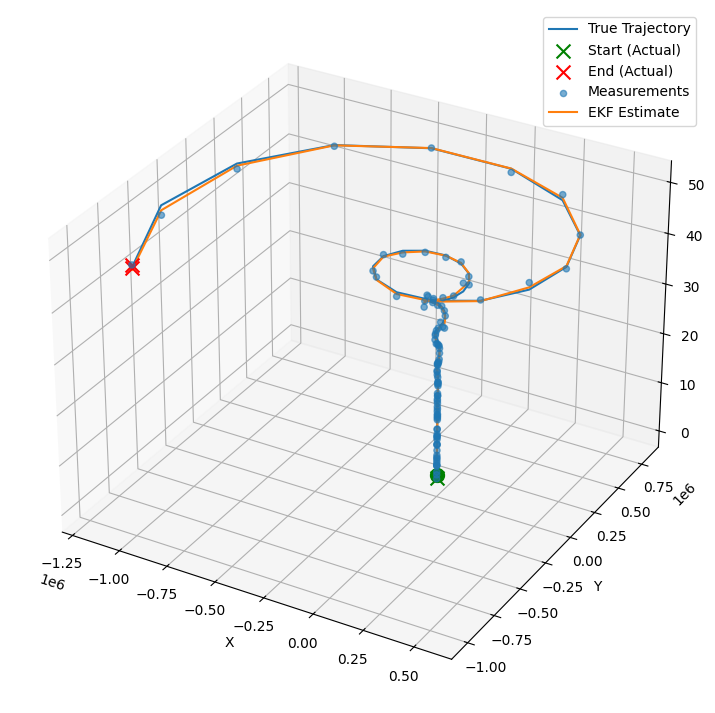

In [6]:
# Simulation parameters
num_steps = 100
dt = 1.0
alpha = 0.01  # Rate of change of angular velocity

# Observation matrix, assuming we can directly observe the x, y, and z position
H = np.eye(3, 5)

# Process noise covariance matrix
Q = np.diag([0.1, 0.1, 0.1, 0.1, 0.01])

# Measurement noise covariance matrix
R = np.diag([0.5, 0.5, 0.5])

# Initial state estimate and covariance
x0 = np.array([0, 20, 0, 0.5, 0.1])  # [x, y, z, v, omega]
P0 = np.eye(5)

# Instantiate the EKF
ekf = ExtendedKalmanFilter(state_transition, jacobian_F, H, jacobian_H, Q, R, x0, P0)

# Generate true trajectory and measurements
true_states = []
measurements = []
for t in range(num_steps):
    u = np.array([dt, alpha])
    true_state = state_transition(x0, u)  # This would be your true system model
    true_states.append(true_state)
    measurement = true_state[:3] + np.random.multivariate_normal(np.zeros(3), R)  # Simulate measurement noise
    measurements.append(measurement)
    x0 = true_state  # Update the true state

# Now we run the EKF over the measurements
estimated_states = []
for z in measurements:
    ekf.predict(u=np.array([dt, alpha]))
    ekf.update(z=np.array(z))
    estimated_states.append(ekf.x)

# Convert lists to arrays for plotting
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)

# Plotting the results
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the true trajectory
ax.plot(true_states[:, 0], true_states[:, 1], true_states[:, 2], label='True Trajectory')
# Increase the size of the start and end markers for the true trajectory
ax.scatter(true_states[0, 0], true_states[0, 1], true_states[0, 2], label='Start (Actual)', c='green', marker='x', s=100)
ax.scatter(true_states[-1, 0], true_states[-1, 1], true_states[-1, 2], label='End (Actual)', c='red', marker='x', s=100)

# Plot the measurements
ax.scatter(measurements[:, 0], measurements[:, 1], measurements[:, 2], label='Measurements', alpha=0.6)
# Plot the start and end markers for the measurements
ax.scatter(measurements[0, 0], measurements[0, 1], measurements[0, 2], c='green', marker='o', s=100)
ax.scatter(measurements[-1, 0], measurements[-1, 1], measurements[-1, 2], c='red', marker='x', s=100)

# Plot the EKF estimate
ax.plot(estimated_states[:, 0], estimated_states[:, 1], estimated_states[:, 2], label='EKF Estimate')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

## References

- https://pykalman.github.io/
- https://github.com/pykalman/pykalman/tree/master